# Reading Raster Data



In [1]:
from IPython.display import display
import pyrasterframes.rf_ipython
import pandas as pd
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
from pyspark.sql.functions import *
spark = create_rf_spark_session()


RasterFrames registers a DataSource named `raster` that enables reading of GeoTIFFs (and other formats when @ref:[GDAL is installed](getting-started.md#installing-gdal)) from arbitrary URIs. The `raster` DataSource operates on either a single raster file location or another DataFrame, called a _catalog_, containing pointers to many raster file locations.

RasterFrames can also read from @ref:[GeoTrellis catalogs and layers](raster-read.md#geotrellis).

## Single Rasters

The simplest way to use the `raster` reader is with a single raster from a single URI or file. In the examples that follow we'll be reading from a Sentinel-2 scene stored in an AWS S3 bucket.



In [2]:
rf = spark.read.raster('https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B02.tif')
rf.printSchema()

root
 |-- proj_raster_path: string (nullable = false)
 |-- proj_raster: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)




The file at the address above is a valid [Cloud Optimized GeoTIFF (COG)](https://www.cogeo.org/), which RasterFrames fully supports. RasterFrames will take advantage of the optimizations in the COG format to enable more efficient reading compared to non-COG GeoTIFFs.

Let's unpack the `proj_raster` column and look at the contents in more detail. It contains a @ref:[_CRS_][CRS], a spatial @ref:[_extent_][Extent] measured in that CRS, and a two-dimensional array of numeric values called a @ref:[_tile_][Tile].



In [3]:
crs = rf.select(rf_crs("proj_raster").alias("value")).first()
print("CRS", crs.value.crsProj4)

CRS +proj=utm +zone=17 +datum=WGS84 +units=m +no_defs 


DataFrame[extent: struct<xmin:double,ymin:double,xmax:double,ymax:double>, tile: udt]
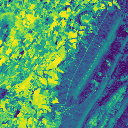
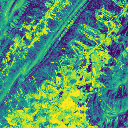
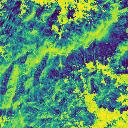
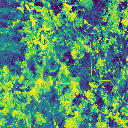
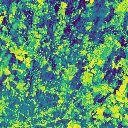

In [4]:
rf.select(
    rf_extent("proj_raster").alias("extent"),
    rf_tile("proj_raster").alias("tile")
)


You can also see that the single raster has been broken out into many rows containing arbitrary non-overlapping regions. Doing so takes advantage of parallel in-memory reads from the cloud hosted data source and allows Spark to work on manageable amounts of data per row. 
The map below shows downsampled imagery with the bounds of the individual tiles.

@@@ note 

The image contains visible "seams" between the tile extents due to reprojection and downsampling used to create the image.
The native imagery in the DataFrame does not contain any gaps in the source raster's coverage.

@@@



In [5]:
from pyrasterframes.rf_types import Extent
import folium 
import pyproj 
from functools import partial
from shapely.ops import transform as shtransform
from shapely.geometry import box
import geopandas
import numpy 

wm_crs = 'EPSG:3857'
crs84 = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Generate overview image
wm_extent = rf.agg(
                  rf_agg_reprojected_extent(rf_extent('proj_raster'), rf_crs('proj_raster'), wm_crs)
                  ).first()[0]
aoi = Extent.from_row(wm_extent)

aspect = aoi.width / aoi.height
ov_size = 1024
ov = rf.agg(
           rf_agg_overview_raster('proj_raster', int(ov_size * aspect), ov_size, aoi)
           ).first()[0]

#  Reproject the web mercator extent to WGS84
project = partial(
        pyproj.transform,
        pyproj.Proj(wm_crs),
        pyproj.Proj(crs84)
    )
crs84_extent = shtransform(project, box(*wm_extent))

# Individual tile WGS84 extents in a dataframe
tile_extents_df = rf.select(
    st_reproject(
        rf_geometry('proj_raster'),
        rf_crs('proj_raster'),
        rf_mk_crs('epsg:4326')
    ).alias('geometry')
).toPandas()

ntiles = numpy.nanquantile(ov.cells, [0.03, 0.97])

# use `filled` because folium doesn't know how to maskedArray
a = numpy.clip(ov.cells.filled(0), ntiles[0], ntiles[1])
 
m = folium.Map([crs84_extent.centroid.y, crs84_extent.centroid.x], 
               zoom_start=9) \
    .add_child(
        folium.raster_layers.ImageOverlay(
            a,
            [[crs84_extent.bounds[1], crs84_extent.bounds[0]],
             [crs84_extent.bounds[3], crs84_extent.bounds[2]]],
            name='rf.proj_raster.tile'
            )
        ) \
    .add_child(folium.GeoJson(
        geopandas.GeoDataFrame(tile_extents_df, crs=crs84),
        name='rf.proj_raster.extent',
        style_function=lambda _: {'fillOpacity':0}
    )) \
    .add_child(folium.LayerControl(collapsed=False))
m



Let's select a single _tile_ and view it. The _tile_ preview image as well as the string representation provide some basic information about the _tile_: its dimensions as numbers of columns and rows and the cell type, or data type of all the cells in the _tile_. For more about cell types, refer to @ref:[this discussion](nodata-handling.md#cell-types).



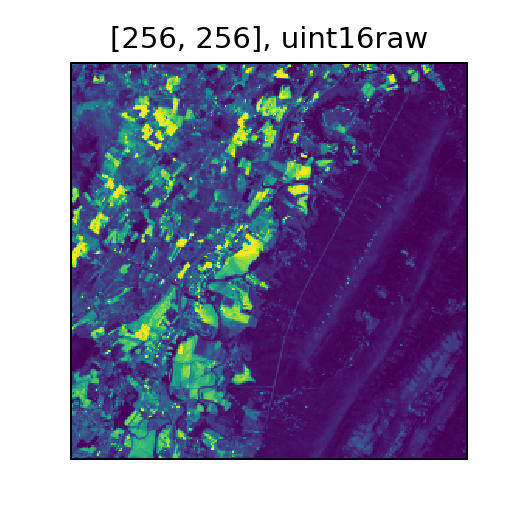

In [6]:
tile = rf.select(rf_tile("proj_raster")).first()[0]
display(tile)


## Multiple Singleband Rasters

In this example, we show the reading @ref:[two bands](concepts.md#band) of [Landsat 8](https://landsat.gsfc.nasa.gov/landsat-8/) imagery (red and near-infrared), combining them with `rf_normalized_difference` to compute [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), a common measure of vegetation health. As described in the section on @ref:[catalogs](raster-catalogs.md), image URIs in a single row are assumed to be from the same scene/granule, and therefore compatible. This pattern is commonly used when multiple bands are stored in separate files.



DataFrame[longitude_latitude: udt, red: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, NIR: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, NDVI: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
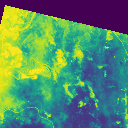
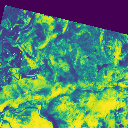
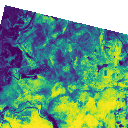
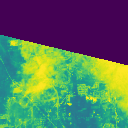
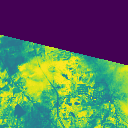
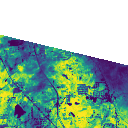
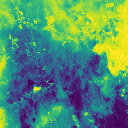
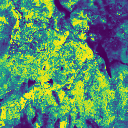
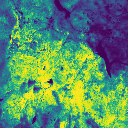
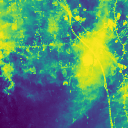
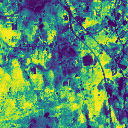
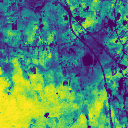
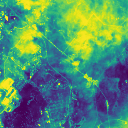
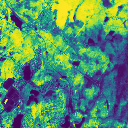
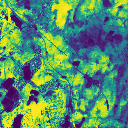

In [7]:
bands = [f'B{b}' for b in [4, 5]]
uris = [f'https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/014/032/LC08_L1TP_014032_20190720_20190731_01_T1/LC08_L1TP_014032_20190720_20190731_01_T1_{b}.TIF' for b in bands]
catalog = ','.join(bands) + '\n' + ','.join(uris)

rf = (spark.read.raster(catalog, bands) 
    # Adding semantic names 
    .withColumnRenamed('B4', 'red').withColumnRenamed('B5', 'NIR')  
    # Adding tile center point for reference 
    .withColumn('longitude_latitude', st_reproject(st_centroid(rf_geometry('red')), rf_crs('red'), lit('EPSG:4326')))
    # Compute NDVI  
    .withColumn('NDVI', rf_normalized_difference('NIR', 'red'))
    # For the purposes of inspection, filter out rows where there's not much vegetation  
    .where(rf_tile_sum('NDVI') > 10000) 
    # Order output 
    .select('longitude_latitude', 'red', 'NIR', 'NDVI')) 
display(rf)


## Multiband Rasters

A multiband raster is represented by a three dimensional numeric array stored in a single file. The first two dimensions are spatial, and the third dimension is typically designated for different spectral @ref:[bands](concepts.md#band). The bands could represent intensity of different wavelengths of light (or other electromagnetic radiation), or they could measure other phenomena such as time, quality indications, or additional gas concentrations, etc.

Multiband rasters files have a strictly ordered set of bands, which are typically indexed from 1. Some files have metadata tags associated with each band. Some files have a color interpetation metadata tag indicating how to interpret the bands.

When reading a multiband raster or a @ref:[_catalog_](#raster-catalogs) describing multiband rasters, you will need to know ahead of time which bands you want to read. You will specify the bands to read, **indexed from zero**, as a list of integers into the `band_indexes` parameter of the `raster` reader.

For example, we can read a four-band (red, green, blue, and near-infrared) image as follows. The individual rows of the resulting DataFrame still represent distinct spatial extents, with a projected raster column for each band specified by `band_indexes`.



DataFrame[proj_raster_path: string, proj_raster_b0: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, proj_raster_b1: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, proj_raster_b2: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, proj_raster_b3: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
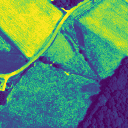
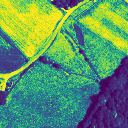
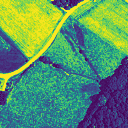
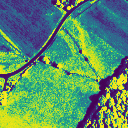
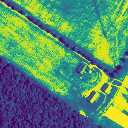
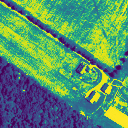
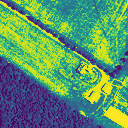
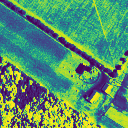
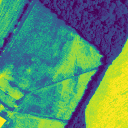
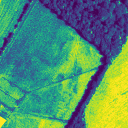
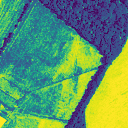
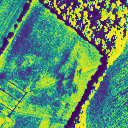
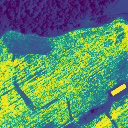
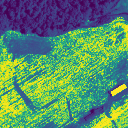
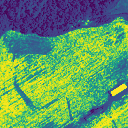
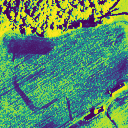
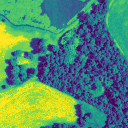
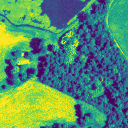
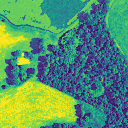
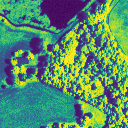

In [8]:
mb = spark.read.raster(
    's3://s22s-test-geotiffs/naip/m_3807863_nw_17_1_20160620.tif',
    band_indexes=[0, 1, 2, 3],
)
display(mb)


If a band is passed into `band_indexes` that exceeds the number of bands in the raster, a projected raster column will still be generated in the schema but the column will be full of `null` values.

You can also pass a _catalog_ and `band_indexes` together into the `raster` reader. This will create a projected raster column for the combination of all items in `catalog_col_names` and `band_indexes`. Again if a band in `band_indexes` exceeds the number of bands in a raster, it will have a `null` value for the corresponding column.

Here is a trivial example with a _catalog_ over multiband rasters. We specify two columns containing URIs and two bands, resulting in four projected raster columns.



In [9]:
import pandas as pd
mb_cat = pd.DataFrame([
    {'foo': 's3://s22s-test-geotiffs/naip/m_3807863_nw_17_1_20160620.tif',
     'bar': 's3://s22s-test-geotiffs/naip/m_3807863_nw_17_1_20160620.tif'
    },
])
mb2 = spark.read.raster(
    spark.createDataFrame(mb_cat),
    catalog_col_names=['foo', 'bar'],
    band_indexes=[0, 1],
    tile_dimensions=(64,64)
)
mb2.printSchema()

root
 |-- foo_path: string (nullable = false)
 |-- bar_path: string (nullable = false)
 |-- foo_b0: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- foo_b1: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string 


## URI Formats

RasterFrames relies on three different I/O drivers, selected based on a combination of scheme, file extentions, and library availability. GDAL is used by default if a compatible version of GDAL (>= 2.4) is installed, and if GDAL supports the specified scheme. If GDAL is not available, either the _Java I/O_ or _Hadoop_ driver will be selected, depending on scheme.

Note: The GDAL driver is the only one that can read non-GeoTIFF files. 


| Prefix              | GDAL        | Java I/O | Hadoop   |
| ------------------- | ----------- | -------- | -------- |
| `gdal://<vsidrv>//` | yes         | no       | no       |
| `file://`           | yes         | yes      | no       |
| `http://`           | yes         | yes      | no       |
| `https://`          | yes         | yes      | no       |
| `ftp://`            | `/vsicurl/` | yes      | no       |
| `hdfs://`           | `/vsihdfs/` | no       | yes      |
| `s3://`             | `/vsis3/`   | yes      | no       |
| `s3n://`            | no          | no       | yes      |
| `s3a://`            | no          | no       | yes      |
| `wasb://`           | `/vsiaz/`   | no       | yes      |
| `wasbs://`          | no          | no       | yes      |

Specific [GDAL Virtual File System drivers](https://gdal.org/user/virtual_file_systems.html) can be selected using the `gdal://<vsidrv>//` syntax. For example If you have a `archive.zip` file containing a GeoTiff named `my-file-inside.tif`, you can address it with `gdal://vsizip//path/to/archive.zip/my-file-inside.tif`. Another example would be a MRF file in an S3 bucket on AWS: `gdal://vsis3/my-bucket/prefix/to/raster.mrf`. See the GDAL documentation for the format of the URIs after the `gdal:/` scheme.


## Raster Catalogs

Consider the definition of a @ref:[_Catalog_](raster-catalogs.md) previously discussed, let's read the raster data contained in the catalog URIs. We will start with the @ref:[external catalog](raster-catalogs.md#using-external-catalogs) of MODIS surface reflectance.



In [10]:
from pyspark import SparkFiles
from pyspark.sql import functions as F

cat_filename = "2018-07-04_scenes.txt"
spark.sparkContext.addFile("https://modis-pds.s3.amazonaws.com/MCD43A4.006/{}".format(cat_filename))

modis_catalog = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load(SparkFiles.get(cat_filename)) \
    .withColumn('base_url',
        F.concat(F.regexp_replace('download_url', 'index.html$', ''), 'gid')
    ) \
    .drop('download_url') \
    .withColumn('red' , F.concat('base_url', F.lit("_B01.TIF"))) \
    .withColumn('nir' , F.concat('base_url', F.lit("_B02.TIF")))

print("Available scenes: ", modis_catalog.count())

Available scenes:  297


In [11]:
modis_catalog

DataFrame[date: string, gid: string, base_url: string, red: string, nir: string]


MODIS data products are delivered on a regular, consistent grid, making identification of a specific area over time easy using [`(h,v)`](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html) grid coordinates (see below).

![MODIS Grid](https://modis-land.gsfc.nasa.gov/images/MODIS_sinusoidal_grid1.gif)

For example, MODIS data right above the equator is all grid coordinates with `v07`.



In [12]:
equator = modis_catalog.where(F.col('gid').like('%v07%')) 
equator.select('date', 'gid')

DataFrame[date: string, gid: string]


Now that we have prepared our catalog, we simply pass the DataFrame or CSV string to the `raster` DataSource to load the imagery. The `catalog_col_names` parameter gives the columns that contain the URI's to be read.



In [13]:
rf = spark.read.raster(equator, catalog_col_names=['red', 'nir'])
rf.printSchema()

root
 |-- red_path: string (nullable = false)
 |-- nir_path: string (nullable = false)
 |-- red: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- nir: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nulla


Observe the schema of the resulting DataFrame has a projected raster struct for each column passed in `catalog_col_names`. For reference, the URI is now in a column appended with `_path`. Taking a quick look at the representation of the data, we see again each row contains an arbitrary portion of the entire scene coverage. We also see that for two-D catalogs, each row contains the same spatial extent for all tiles in that row.



DataFrame[gid: string, rf_extent(red): struct<xmin:double,ymin:double,xmax:double,ymax:double>, rf_extent(nir): struct<xmin:double,ymin:double,xmax:double,ymax:double>, rf_tile(red): udt, rf_tile(nir): udt]
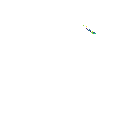
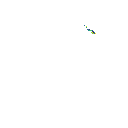
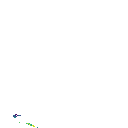
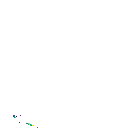
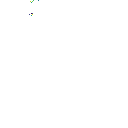
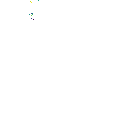

In [14]:
sample = rf \
    .select('gid', rf_extent('red'), rf_extent('nir'), rf_tile('red'), rf_tile('nir')) \
    .where(~rf_is_no_data_tile('red'))
sample.limit(3)


## Lazy Raster Reading

By default, reading raster pixel values is delayed until it is absolutely needed. The DataFrame will contain metadata and pointers to the appropriate portion of the data until reading of the source raster data is absolutely necessary. This can save a significant of computation and I/O time for two reasons. First, a catalog may contain a large number of rows. Second, the `raster` DataSource attempts to apply spatial preciates (e.g. `where`/`WHERE` clauses with `st_intersects`, et al.) at row creation, reducing the chance of unneeded data being fetched.

Consider the following two reads of the same data source. In the first, the lazy case, there is a pointer to the URI, extent and band to read. This will not be evaluated until the cell values are absolutely required. The second case shows the option to force the raster to be fully loaded right away.



In [15]:
uri = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B02.tif'
lazy = spark.read.raster(uri).select(col('proj_raster.tile').cast('string'))
lazy

DataFrame[tile: string]

In [16]:
non_lazy = spark.read.raster(uri, lazy_tiles=False).select(col('proj_raster.tile').cast('string'))
non_lazy

DataFrame[tile: string]


In the initial examples on this page, you may have noticed that the realized (non-lazy) _tiles_ are shown, but we did not change `lazy_tiles`. Instead, we used @ref:[`rf_tile`](reference.md#rf-tile) to explicitly request the realized _tile_ from the lazy representation.

## Spatial Indexing and Partitioning

It's often desirable to take extra steps in ensuring your data is effectively distributed over your computing resources. One way of doing that is using something called a ["space filling curve"](https://en.wikipedia.org/wiki/Space-filling_curve), which turns an N-dimensional value into a one dimensional value, with properties that favor keeping entities near each other in N-space near each other in index space. In particular RasterFrames support space-filling curves mapping the geographic location of _tiles_ to a one-dimensional index space called [`xz2`](https://www.geomesa.org/documentation/user/datastores/index_overview.html). To have RasterFrames add a spatial index based partitioning on a raster reads, use the `spatial_index_partitions` parameter. By default it will use the same number of partitions as configured in [`spark.sql.shuffle.partitions`](https://spark.apache.org/docs/latest/sql-performance-tuning.html#other-configuration-options).
 


DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, spatial_index: bigint]
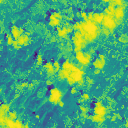
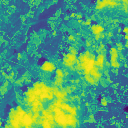
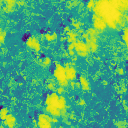

In [17]:
df = spark.read.raster(uri, spatial_index_partitions=True)
df


You can also pass a positive integer to the parameter to specify the number of desired partitions.



In [18]:
df = spark.read.raster(uri, spatial_index_partitions=800)


## GeoTrellis

### GeoTrellis Catalogs

[GeoTrellis][GeoTrellis] is one of the key libraries upon which RasterFrames is built. It provides a Scala language API for working with geospatial raster data.  GeoTrellis defines a [tile layer storage](https://geotrellis.readthedocs.io/en/latest/guide/tile-backends.html) format for persisting imagery mosaics. RasterFrames provides a DataSource supporting both @ref:[reading](raster-read.md#geotrellis-layers) and @ref:[writing](raster-write.md#geotrellis-layers) GeoTrellis layers.

A GeoTrellis catalog is a set of GeoTrellis layers. We can read a DataFrame giving details of the content of a catalog using the syntax below. The scheme is typically `hdfs` or `file`, or a cloud storage provider like `s3`.



In [19]:
gt_cat = spark.read.geotrellis_catalog('scheme://path-to-gt-catalog')


### GeoTrellis Layers

The catalog will give details on the individual layers available for query. We can read each layer with the URI to the catalog, the layer name, and the desired zoom level.



In [20]:
gt_layer = spark.read.geotrellis(path='scheme://path-to-gt-catalog', layer=layer_name, zoom=zoom_level)


This will return a RasterFrame with additional [GeoTrellis-specific metadata](https://geotrellis.readthedocs.io/en/latest/guide/core-concepts.html#layouts-and-tile-layers), inherited from GeoTrellis, stored as JSON in the metadata of the _tile_ column.

[CRS]: concepts.md#coordinate-reference-system--crs
[Extent]: concepts.md#extent
[Tile]: concepts.md#tile
[GeoTrellis]: https://geotrellis.readthedocs.io/en/latest/
